# Globals

In [ ]:
root_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/"
path_pesi_old = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/history.json"
save_checkpoints_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt"
path_root = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs"

In [ ]:
class_index = {'Adialer.C': 0,
              'Agent.FYI': 1,
              'Allaple.A': 2,
              'Allaple.L': 3,
              'Alueron.gen!J': 4,
              'Autorun.K': 5,
              'Benign': 6,
              'C2LOP.P': 7,
              'C2LOP.gen!g': 8,
              'Dialplatform.B': 9,
              'Dontovo.A': 10,
              'Fakerean': 11,
              'Instantaccess': 12,
              'Lolyda.AA1': 13,
              'Lolyda.AA2': 14,
              'Lolyda.AA3': 15,
              'Lolyda.AT': 16,
              'Malex.gen!J': 17,
              'Obfuscator.AD': 18,
              'Rbot!gen': 19,
              'Skintrim.N': 20,
              'Swizzor.gen!E': 21,
              'Swizzor.gen!I': 22,
              'VB.AT': 23,
              'Wintrim.BX': 24,
              'Yuner.A': 25}

# Setting up the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
train_df=pd.read_csv(os.path.join(path_root,"train_combined3.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_combined3.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_combined3.csv"))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 6214 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.
Found 2054 validated image filenames belonging to 26 classes.


In [ ]:
classes = train_gen.class_indices

# Image plot of malware samples


In [ ]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,len(classes)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)

        img = cv2.imread(ims[i])
        img = cv2.resize(img,target_size_custom) #per plottare senza preprocessing

        plt.imshow(img,cmap='gray', interpolation=None if interp else 'none')

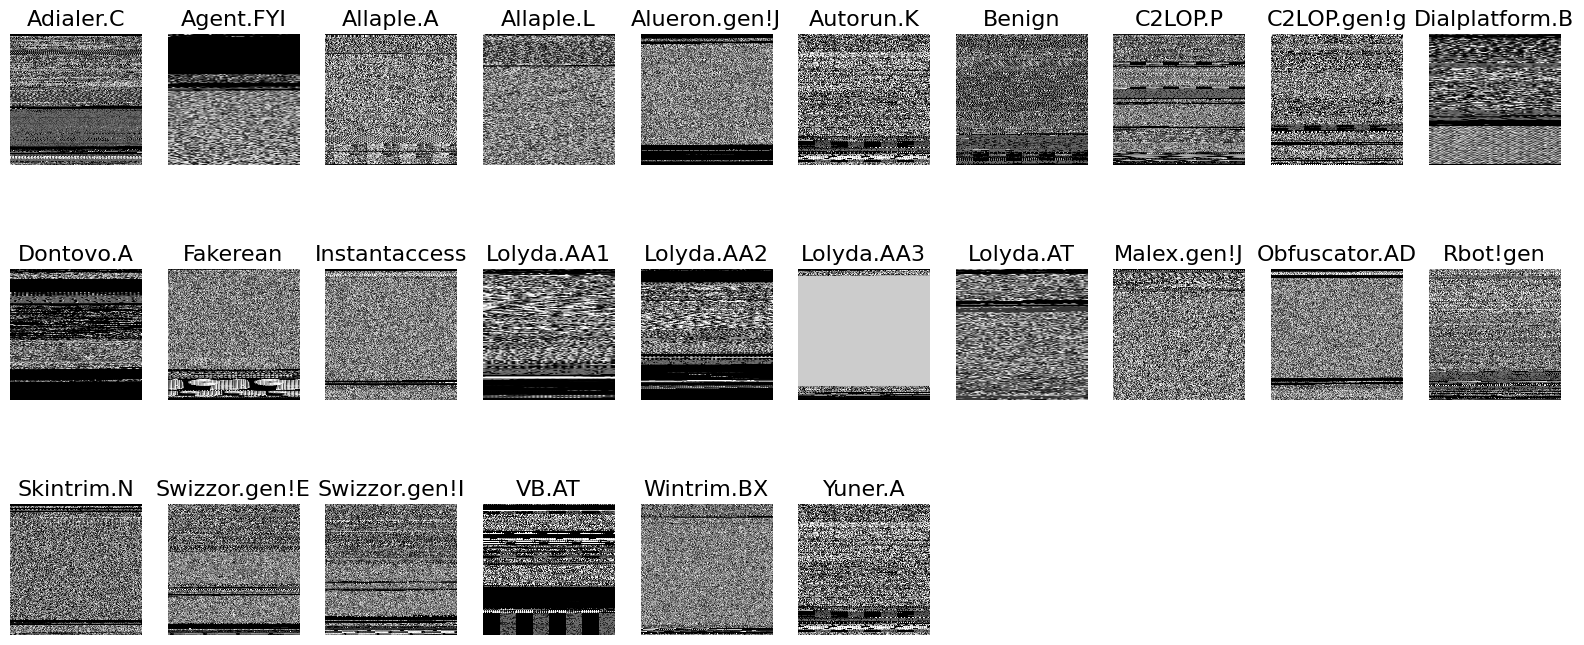

In [ ]:
base_path_benign = "/content/drive/MyDrive/progetto_SS/benign_data/benign_img"
base_path_malign = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/"

samples = []
keys = []

for classe in classes:
  if(classe != "Benign"):
    samples.append(os.path.join(base_path_malign,classe,os.listdir(os.path.join(base_path_malign,classe))[0]))
  else:
    samples.append(os.path.join(base_path_benign,os.listdir(base_path_benign)[1]))
  keys.append(classe)

plots(samples, titles = keys)

# Analysis of class distribution


In [ ]:
total_samples = pd.concat([train_df, test_df, val_df], ignore_index=True)

In [ ]:
total_samples

,Unnamed: 0,img_code,target
0,0,./Adialer.C/0441274bb0fcae858179dfe242b6d2a1.png,Adialer.C
1,1,./Adialer.C/04a807a2dc9a7ce9d31decb0e15451d1.png,Adialer.C
2,2,./Adialer.C/05042268ee4fa6959f49e1d99d30fd71.png,Adialer.C
3,3,./Adialer.C/050f962b76f3b115044873d9e3a07a97.png,Adialer.C
4,4,./Adialer.C/048cd7efed7099c53caaa2da4b01a633.png,Adialer.C
...,...,...,...
10317,2049,/content/drive/MyDrive/progetto_SS/benign_data...,Benign
10318,2050,/content/drive/MyDrive/progetto_SS/benign_data...,Benign
10319,2051,/content/drive/MyDrive/progetto_SS/benign_data...,Benign
10320,2052,/content/drive/MyDrive/progetto_SS/benign_data...,Benign


In [ ]:
occurences = total_samples.groupby(by = "target").size()

Unbalanced class distribution makes the training biased towards the popular classes.

<BarContainer object of 26 artists>

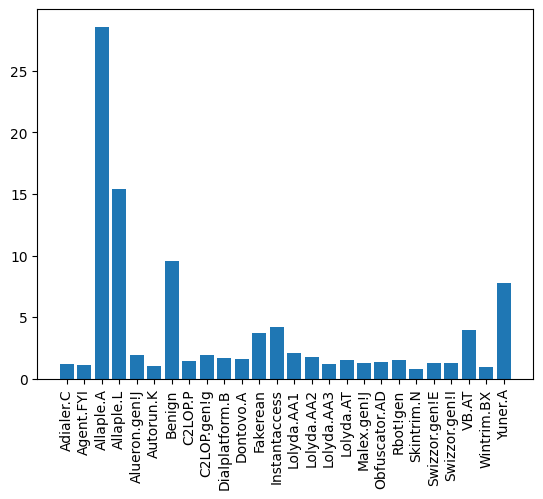

In [ ]:
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), occurences/sum(occurences)*100)

# Analysis of class distribution for each subset

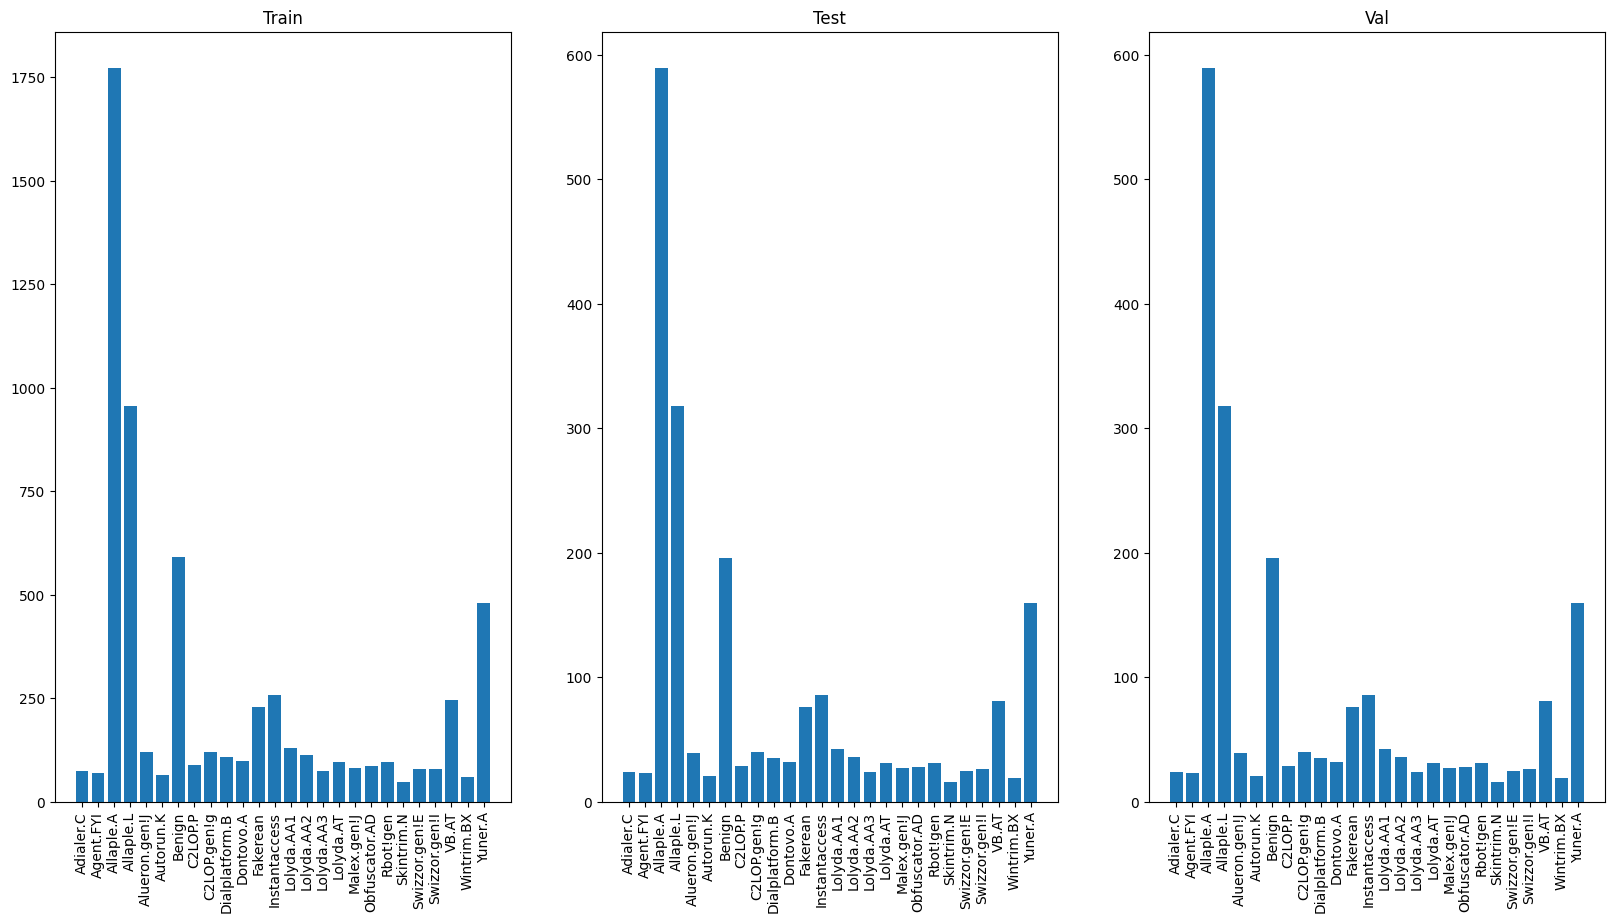

In [ ]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ, val_occ]
name = ["Train", "Test", "Val"]

plt.figure(figsize = (20,10))

for i in range(3):

  plt.subplot(1,3,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

# Class weight calculation

In [ ]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 3.22972972972973,
 1: 3.414285714285714,
 2: 0.13495200451722192,
 3: 0.25026178010471206,
 4: 1.9916666666666667,
 5: 3.734375,
 6: 0.40439932318104904,
 7: 2.715909090909091,
 8: 1.9916666666666667,
 9: 2.2336448598130842,
 10: 2.438775510204082,
 11: 1.0436681222707425,
 12: 0.9227799227799228,
 13: 1.8527131782945736,
 14: 2.1339285714285716,
 15: 3.1866666666666665,
 16: 2.463917525773196,
 17: 2.9146341463414633,
 18: 2.7790697674418605,
 19: 2.4895833333333335,
 20: 4.979166666666667,
 21: 3.0641025641025643,
 22: 2.9875,
 23: 0.9715447154471545,
 24: 4.0508474576271185,
 25: 0.4979166666666667}

<BarContainer object of 26 artists>

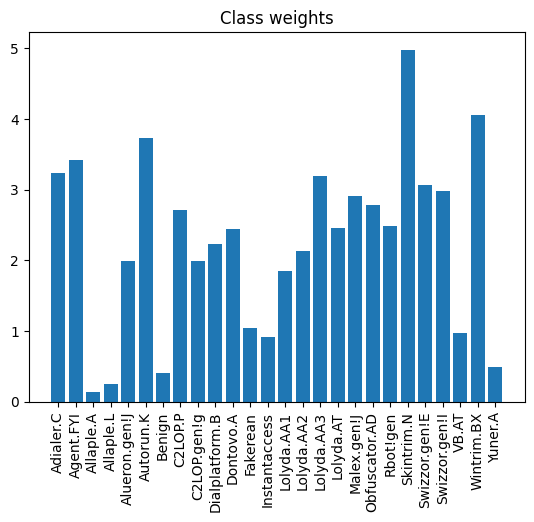

In [ ]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# Building the CNN

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [ ]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [ ]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 30, 30, 32)      

In [ ]:
cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [ ]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

# Training

In [ ]:
history = Malware_model.fit(train_gen,validation_data=val_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 2.7706 - accuracy: 0.1775 - weighted_accuracy: 0.1900
Epoch 1: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 1510s 8s/step - loss: 2.7706 - accuracy: 0.1775 - weighted_accuracy: 0.1900 - val_loss: 2.4557 - val_accuracy: 0.6130 - val_weighted_accuracy: 0.6130
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 1.5617 - accuracy: 0.5235 - weighted_accuracy: 0.5462
Epoch 2: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 46s 236ms/step - loss: 1.5617 - accuracy: 0.5235 - weighted_accuracy: 0.5462 - val_loss: 0.7313 - val_accuracy: 0.7848 - val_weighted_accuracy: 0.7848
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.8654 - accuracy: 0.7403 - weighted_accuracy: 0.7189
Epoch 3: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 46s 233ms/step - loss: 0.8654 - accuracy: 0.7403 - weighted_accuracy: 0.7189 - val_loss: 0.4764 - val_accuracy: 0.8627 - val_weighted_accuracy: 0.8627
Epoch 4/10
195/195 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.8037 - weighted_accuracy: 0.7900
Epoch 4: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 43s 219ms/step - loss: 0.5857 - accuracy: 0.8037 - weighted_accuracy: 0.7900 - val_loss: 0.3208 - val_accuracy: 0.8476 - val_weighted_accuracy: 0.8476
Epoch 5/10
195/195 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8388 - weighted_accuracy: 0.8343
Epoch 5: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 43s 221ms/step - loss: 0.4732 - accuracy: 0.8388 - weighted_accuracy: 0.8343 - val_loss: 0.2896 - val_accuracy: 0.9056 - val_weighted_accuracy: 0.9056
Epoch 6/10
195/195 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8487 - weighted_accuracy: 0.8414
Epoch 6: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 43s 219ms/step - loss: 0.4290 - accuracy: 0.8487 - weighted_accuracy: 0.8414 - val_loss: 0.2167 - val_accuracy: 0.9401 - val_weighted_accuracy: 0.9401
Epoch 7/10
195/195 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8787 - weighted_accuracy: 0.8547
Epoch 7: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 45s 229ms/step - loss: 0.3608 - accuracy: 0.8787 - weighted_accuracy: 0.8547 - val_loss: 0.2079 - val_accuracy: 0.9435 - val_weighted_accuracy: 0.9435
Epoch 8/10
195/195 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8886 - weighted_accuracy: 0.8652
Epoch 8: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 44s 227ms/step - loss: 0.3360 - accuracy: 0.8886 - weighted_accuracy: 0.8652 - val_loss: 0.2629 - val_accuracy: 0.8656 - val_weighted_accuracy: 0.8656
Epoch 9/10
195/195 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8938 - weighted_accuracy: 0.8720
Epoch 9: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 44s 223ms/step - loss: 0.3133 - accuracy: 0.8938 - weighted_accuracy: 0.8720 - val_loss: 0.2140 - val_accuracy: 0.8749 - val_weighted_accuracy: 0.8749
Epoch 10/10
195/195 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8933 - weighted_accuracy: 0.8795
Epoch 10: saving model to /content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_val/modellozzo_ckpt


195/195 [==============================] - 44s 224ms/step - loss: 0.2968 - accuracy: 0.8933 - weighted_accuracy: 0.8795 - val_loss: 0.1689 - val_accuracy: 0.9547 - val_weighted_accuracy: 0.9547


## History saving

In [ ]:
hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

## Model training plots

dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


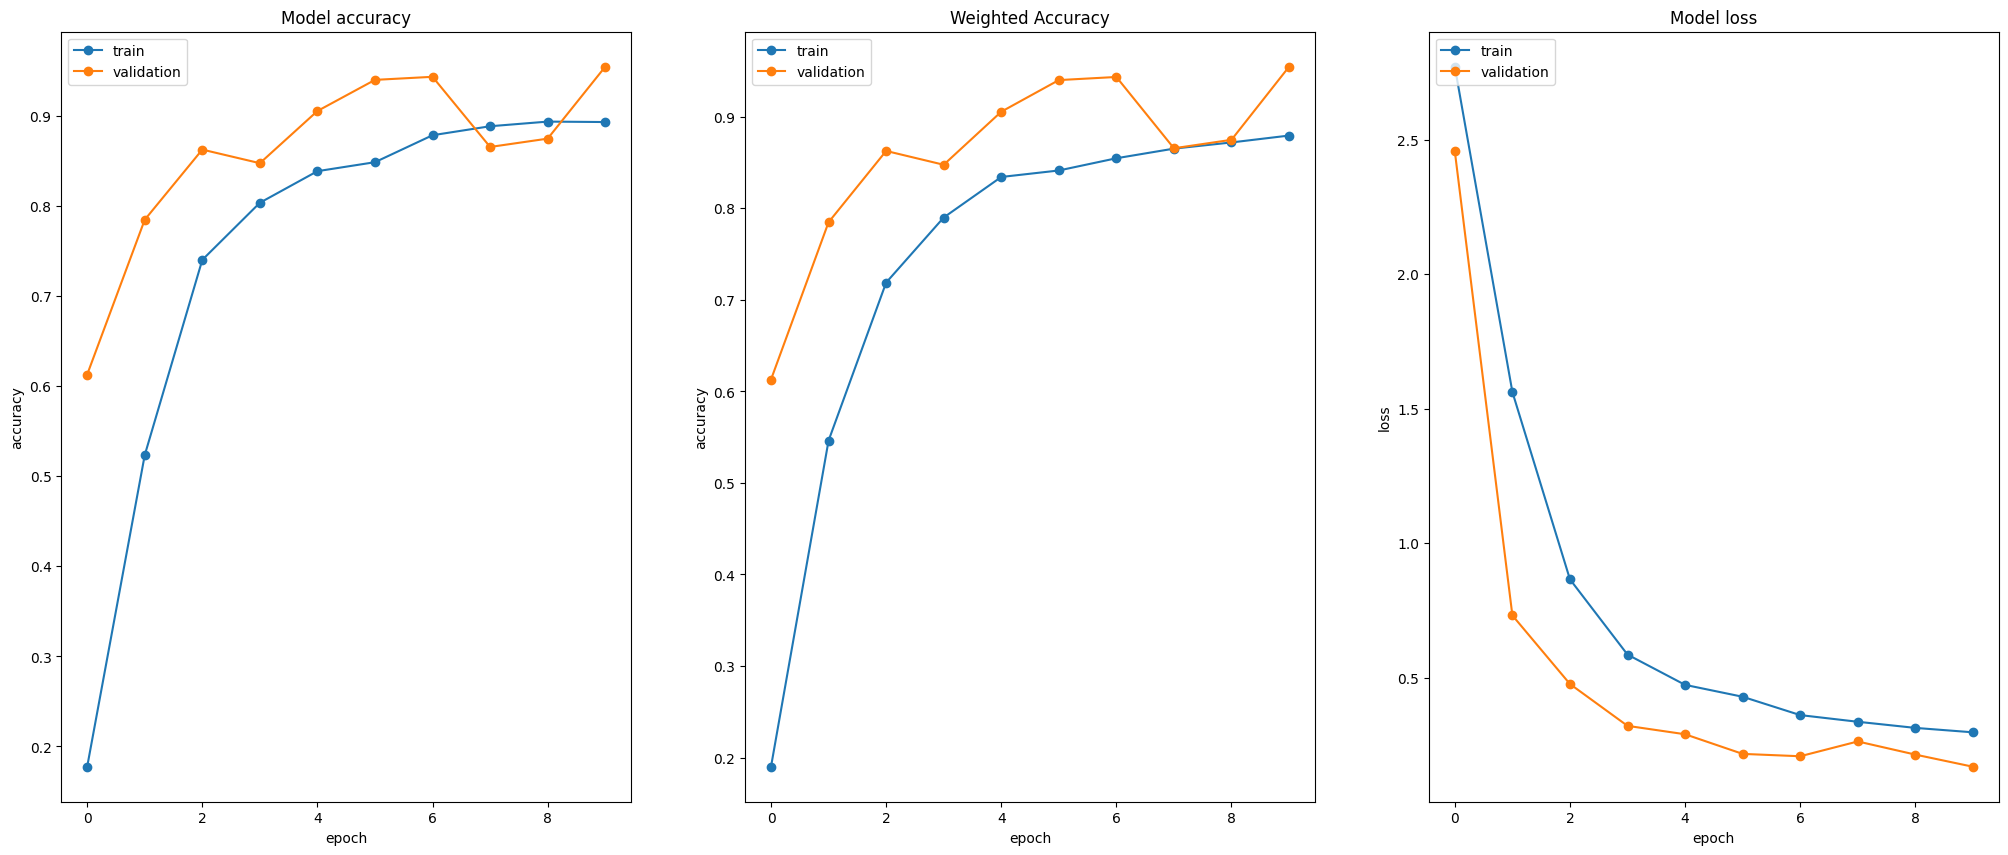

In [ ]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.plot(history.history['val_weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Results on Validation Set

In [ ]:
metric_list = Malware_model.evaluate(val_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

65/65 [==============================] - 9s 134ms/step - loss: 0.1689 - accuracy: 0.9547 - weighted_accuracy: 0.9547
evaluate_accuracy=0.955
evaluate_weighted_accuracy=0.955


## Confusion matrix

In [ ]:
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)



y_pred = Malware_model.predict(val_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

Found 2054 validated image filenames belonging to 26 classes.
65/65 [==============================] - 11s 161ms/step


In [ ]:
from sklearn import metrics

In [ ]:
c_matrix = metrics.confusion_matrix(val_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(val_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [ ]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

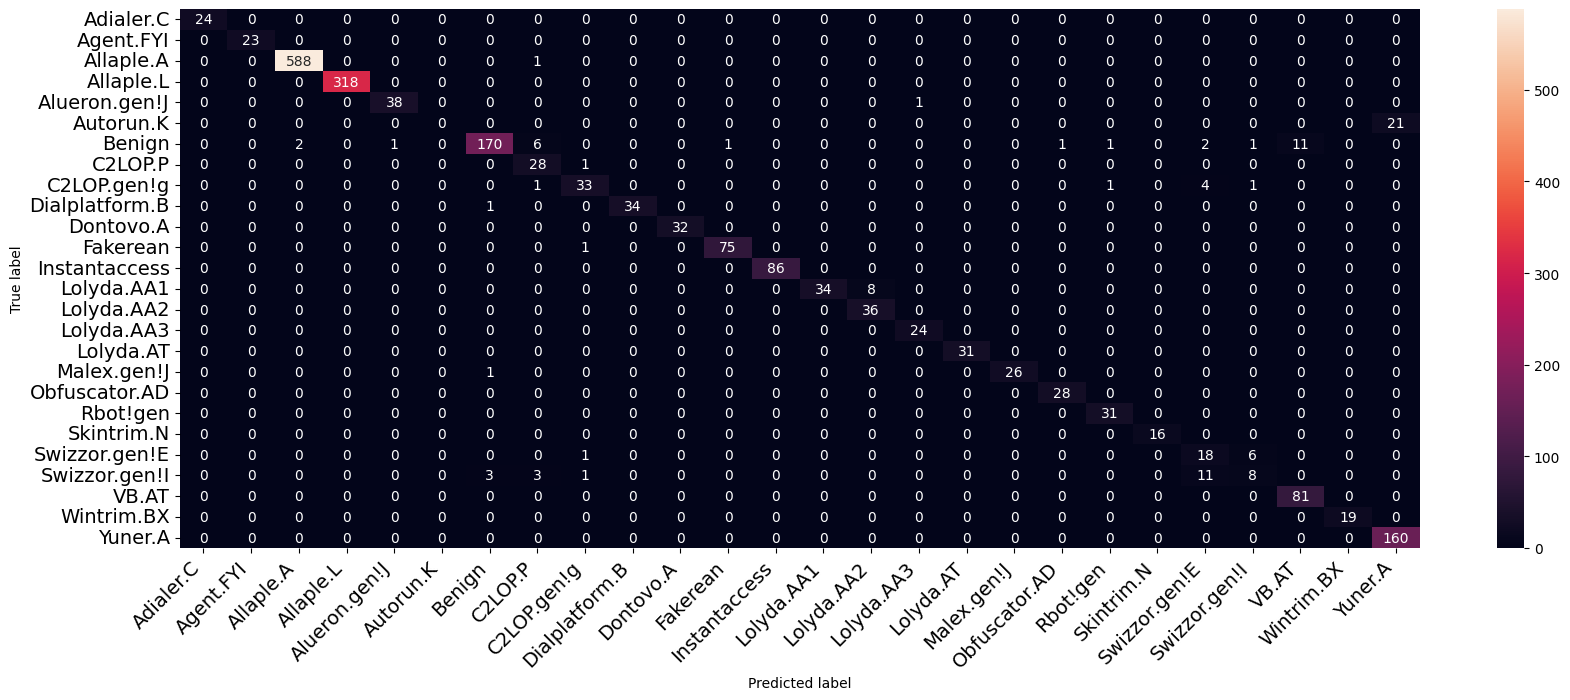

In [ ]:
confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [ ]:
report = metrics.classification_report(val_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)

{'Adialer.C': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}, 'Agent.FYI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'Allaple.A': {'precision': 0.9966101694915255, 'recall': 0.99830220713073, 'f1-score': 0.9974554707379135, 'support': 589}, 'Allaple.L': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 318}, 'Alueron.gen!J': {'precision': 0.9743589743589743, 'recall': 0.9743589743589743, 'f1-score': 0.9743589743589743, 'support': 39}, 'Autorun.K': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'Benign': {'precision': 0.9714285714285714, 'recall': 0.8673469387755102, 'f1-score': 0.9164420485175201, 'support': 196}, 'C2LOP.P': {'precision': 0.717948717948718, 'recall': 0.9655172413793104, 'f1-score': 0.8235294117647058, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.8918918918918919, 'recall': 0.825, 'f1-score': 0.8571428571428571, 'support': 40}, 'Dialplatform.B': {'precision': 1.0, 'recall': 0.9714285714285714,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(root_path,"report.csv"))